# Data Preprocessing

In [5]:
from utils import Params
import dsp_utils
import librosa
import numpy as np
from dsp_utils import spectrogram2wav
from scipy.io.wavfile import write 
params = Params('./runs/default/params.json')
fpath = '../data/lj-speech/LJSpeech-1.0/wavs/LJ001-0006.wav/'
# dsp_utils.get_spectrograms(fpath,params)

In [12]:
y, sr = librosa.load(fpath,sr=params.sampling_rate)
y, _ = librosa.effects.trim(y)

In [13]:
y1 = np.append(y[0], y[1:] - 0.97 * y[:-1])

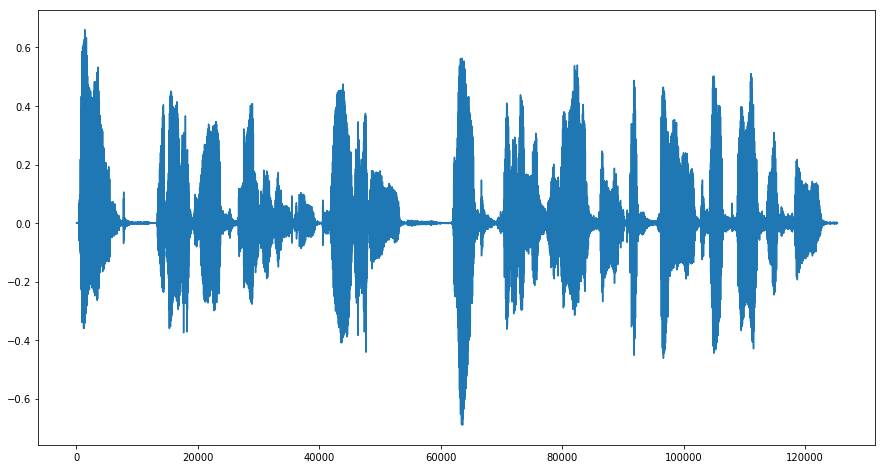

In [14]:
fig, ax = plt.subplots(figsize=(15,8))
plt.plot(y)
plt.show()

In [15]:
mag = np.abs(librosa.stft(y,params.n_fft,params.hop_length))
np.max(mag)

93.88488

In [6]:
mel, mag = dsp_utils.get_spectrograms(fpath,params)

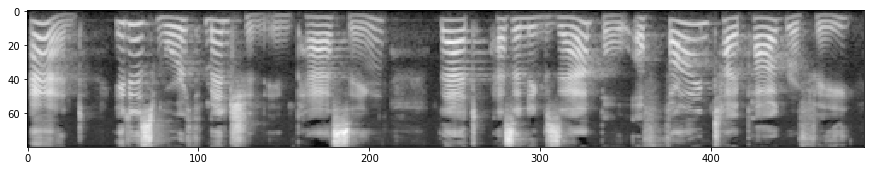

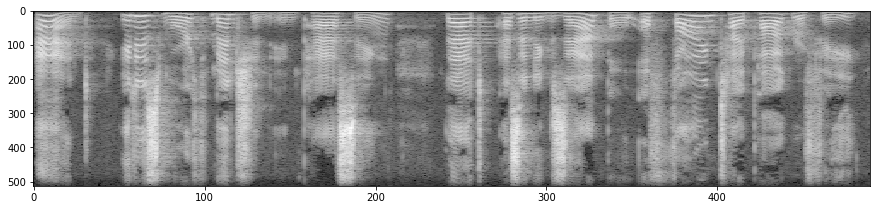

In [7]:
fig, ax = plt.subplots(figsize=(15,8))
ax.imshow(mel.T,cmap='gray',aspect=1)
plt.show()
fig, ax = plt.subplots(figsize=(15,8))
ax.imshow(mag.T,cmap='gray',aspect=0.2)
plt.show()

In [8]:
wav = dsp_utils.spectrogram2wav(mag,params)
dsp_utils.save_wav(wav,'./dsp_tests/out_test.wav',params.sampling_rate)

In [9]:
mag_denorm = dsp_utils._denormalize(mag,params)

## Train / Dev data split

In [1]:
import os,sys
import glob
import pandas as pd
import collections

In [2]:
csv_path = '../data/lj-speech/LJSpeech-1.0/metadata.csv'
transcripts_all = pd.read_csv(csv_path,sep='|',header=None)
transcripts_all.head()

,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...


In [21]:
dev_fraction = 0.2
rand_state = np.random.RandomState(4)
transcripts_val = transcripts_all.sample(frac=dev_fraction,random_state=rand_state)
transcripts_train = transcripts_all[~(transcripts_all[0].isin(transcripts_dev[0]))]
print(transcripts_val.shape)
print(transcripts_train.shape)

(2620, 3)
(10480, 3)


In [22]:
# write out to separate files 
transcripts_val.to_csv('../data/lj-speech/LJSpeech-1.0/val.csv',sep='|',index=False,header=None)
transcripts_train.to_csv('../data/lj-speech/LJSpeech-1.0/train.csv',sep='|',index=False,header=None)

## Organizing gspeech dataset

In [2]:
# get list of filenames, split by folder 
file_paths = glob.glob("../data/google-speech-commands/*/*.wav")
label_dict = collections.defaultdict(list)
for path in file_paths:
    fname = os.path.split(path)[1]
    label = os.path.split(os.path.dirname(path))[1]
    label_dict[label].append(fname)

In [3]:
label_DF = pd.DataFrame.from_dict(label_dict,orient='index')
label_DF = label_DF.T.melt(var_name='label',value_name='fname').dropna()
label_DF = label_DF.set_index('label').drop('_background_noise_')

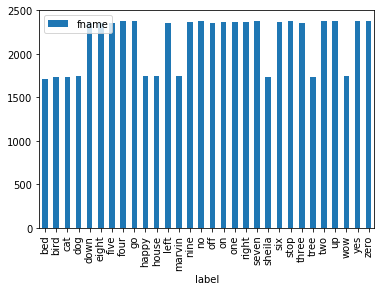

In [4]:
label_DF.groupby('label').agg('count').plot(kind='bar')
plt.show()

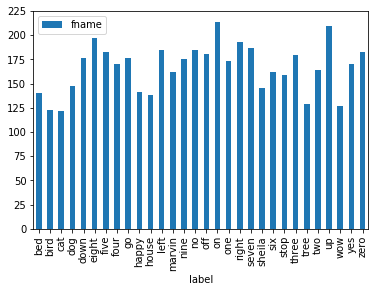

In [5]:
sampled_DF = label_DF.sample(5000).reset_index()
sampled_DF.groupby('label').agg('count').plot(kind='bar')
plt.show()

In [13]:
sampled_DF.fname = sampled_DF.fname.apply(lambda x: x.split('.')[0])
sampled_DF = sampled_DF[['fname','label']]
sampled_DF['label_norm'] = sampled_DF['label']

In [15]:
# create subset of data
dirname = '../data/gspeech-sample/'
sourcedir = '../data/google-speech-commands/'
destdir = os.path.join(dirname,'wavs') 

# copy files over
os.mkdir(destdir)
for index,row in sampled_DF.iterrows():
    print(index),
    fname,label = row['fname']+'.wav',row['label']
    os.system("cp {} {}".format(os.path.join(sourcedir,label,fname),
                                os.path.join(destdir,fname)))
    sys.stdout.flush()
# write out label csv file
sampled_DF.to_csv(os.path.join(dirname,'metadata.csv'),index=False,header=False,sep='|')

FileExistsError: [Errno 17] File exists: '../data/gspeech-sample/wavs'